# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc.

Our GAN uses from the folowing project, however our GAN network uses Fully Connected layers and No Convolutions layers:

-   Radford, Alec, Luke Metz, and Soumith Chintala. “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” ArXiv:1511.06434 [Cs], January 7, 2016. http://arxiv.org/abs/1511.06434

-------------
## Import necessary packages

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn
from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from typing import Set
from collections import namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
device = None
if torch.cuda.is_available():
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True 
    print("GPU training available")  
    device = torch.device("cuda:0")
    print(f"Index of currently used CUDA device is {torch.cuda.current_device()}")
else: 
    print("GPU training NOT available")  
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of currently used CUDA device is 0


-----
## Configuration
### Hyper parameters
Set up Hyper Parameters that our model needs.

We need to define several hyper parameters for our model:
1. Latent size
2. Hidden size
3. Input image size
4. Number of epochs
5. Batch size
6. Learning rate
7  Beta1 for ADAM Optimizer
8. Output Directory for generated images

In [3]:
class HyperParameter():
    
    def __init__(self, latent_sz, in_img_size, in_img_channel=3, data_dir="../data/img_align_celeba", output_dir="../generated_imgs", 
                       lr=0.0002, beta1=0.5, epochs=100, batch_sz=64, d_trained_wt_dir="../discriminator_trained_weights",
                       g_trained_wt_dir="../generator_trained_weights"):
        self.latent_size = latent_sz
        self.learning_rate = lr
        self.beta1 = beta1
        
        self.epochs = epochs
        self.batch_size = batch_sz
        self.input_img_channel = in_img_channel
        self.input_img_size = in_img_size
        
        self.discriminator_trained_weight_dir = d_trained_wt_dir
        self.generator_trained_weight_dir = g_trained_wt_dir
        self.output_dir = output_dir
        self.data_dir = data_dir
        
        os.makedirs(self.discriminator_trained_weight_dir, exist_ok=True)
        os.makedirs(self.generator_trained_weight_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)
    
    def __repr__(self):
        return f"latent_size: {self.latent_size}\n" + \
               f"learning_rate: {self.learning_rate}\n" + \
               f"beta1: {self.beta1}\n" + \
               f"input_img_size: {self.input_img_size}\n" + \
               f"input_img_channel: {self.input_img_channel}\n" + \
               f"epochs: {self.epochs}\n" + \
               f"batch_size: {self.batch_size}\n" + \
               f"data_dir: {self.data_dir}\n" + \
               f"output_dir: {self.output_dir}\n" + \
               f"discriminator_trained_weight_dir: {self.discriminator_trained_weight_dir}\n" + \
               f"generator_trained_weight_dir: {self.generator_trained_weight_dir}\n"

The **Hyper Parameter Class can be set up like so**

```python
hyper_parms = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, output_dir="../generated_imgs", lr=0.0002, beta1=0.5, epochs=100, batch_sz=64)
```

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Resize(64)


In [4]:
img_data_transform = transforms.Compose([
                    transforms.CenterCrop(160),
                    transforms.Resize(64),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalizes imgs in the range [-1,1]

-----
##  Data Loading
Next, we are going to load our data. 
### First, we need to prepare our data:
#### we use the following command to download our data:

```shell
$ apt-get install p7zip-full # ubuntu

$ brew install p7zip         # OSX

$ python download.py
```

-----
### Import the necessary library for data loading

In [5]:
import os.path
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm

import torch.utils.data as data
import torchvision.datasets as datasets
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

### We first define several helper functions that can help use to load each item in the dataset.

1.   We first create a list that contains all image files.    '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',.

2.   We define function `is_image_file()` which takes the file name as the input:
    <br />a. Return True if it is a valid image file else False
    
3.   We define `make_dataset()` function which takes a file path as the input:
    <br />a. Go over the path and find files
    <br />b. If it is a valid img file, store it to a list
    <br />c. Return the list
    
4.   Finally, create a function that is called default_loader()
    <br />a. that will open the image and convert it to the RGB using Image.open() and convert()

## Utility Functions

In [6]:
VALID_IMG_EXTENSIONS = {'.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP'}

def _is_image_file(fpath, valid_img_ext: Set=VALID_IMG_EXTENSIONS) -> bool:
    """Validates if a file is an img file"""
    _, img_ext = os.path.splitext(fpath)
    return img_ext in valid_img_ext

def make_img_dataset(root_dir, valid_img_ext: Set=VALID_IMG_EXTENSIONS):
    """Returns a list of valid img files after recursively chking in rootdir"""
    img_dataset = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if _is_image_file(file, valid_img_ext):
                img_path = os.path.join(subdir, file)
                img_dataset.append(img_path)
                
    return img_dataset

def default_loader(img):
    """Converts img file into RGB mode"""
    try:
        opened_img = Image.open(img)
        return opened_img.convert('RGB')
    except Exception as e:
        print(f"Exception: {e}. Skipping {img}")
        return False

### We then can use those helper functions to create our dataloader that load each item.  For this we creat a ImageDataset(data.Dataset) class

1. This function is initialized with root, train transform, target transform and loader
    <br /> a. We get all images using the utility functions we defined
    <br /> b. If there are no valid images we raise an proper error
    <br /> c. Print the length of valid data

2. We need to define a __getitem__() function that take index as input
    <br /> a. For the "index" element in the img list
         i.   Apply the transform
    <br /> b. Return the img and target.

3. We define a __len__() function that retrun the length of the dataset

In [7]:
class ImageDataset(Dataset):
    
    def __init__(self, root_dir, transform=None, 
                 valid_img_ext: Set=VALID_IMG_EXTENSIONS):
        self.transform = transform
        
        self.face_dataset = make_img_dataset(root_dir, valid_img_ext)
        if len(self.face_dataset) == 0:
            raise IndexError("Face dataset is empty")
        
    def __len__(self):
        return len(self.face_dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.face_dataset[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image

### We then define our data loader get_loader()
#### This func has 5 arguments
1. root
2. batch size
3. scale size (img_data_transform)
4. number of workers
5. shuffle

<br /> We create a data_loader using torch.utils.data.DataLoader() with proper parameters

In [8]:
def get_data_loader(root_data_dir,
                    data_transform = img_data_transform, 
                    batch_size = 64,
                    num_workers = 2, 
                    shuffle = True,
                    drop_last=True):
    """
    root_dir is the directory with the images
    """
    face_dataset = ImageDataset(root_data_dir, 
                                data_transform)
    data_loader = torch.utils.data.DataLoader(face_dataset, 
                                       batch_size=batch_size, 
                                       num_workers=num_workers,
                                       shuffle=shuffle,
                                       drop_last=True)
    return data_loader

Then, we use the function above to load the data to data_loader variables which will be called before training our GAN

```python
train_data_loader = get_data_loader(hyper_parms.data_dir, batch_size=hyper_parms.batch_size, num_workers=5)
```

-----
##  Network

To design our GAN network, we use `nn.Sequential()` to stack several layers and activation functions

### First, we create our Discriminator

1. We use one Input layer, one Hidden layer and one Output layer. All of them are defined using nn.Linear() with proper input dim and out dim

2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 

3. We use nn.Sigmoid() activation function for the output layer

### Next, we make our Generator 

1. We need one Input layer, two Hidden layers and one Output layer. All of them are defined using nn.Linear() with proper input and output dimension

2. We use nn.ReLU() as activation functions for the Input and Hidden layer. 

3. We use nn.Tanh() as activation function for the Output layer

## Discriminator

####  Structure of the Discriminator module as follow:

1.	The input of the first linear layer is the image size (64), output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the LeakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the LeakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, input_img_size=64, input_img_channels=3, n_gpu=1):
        super(Discriminator, self).__init__()
        self.n_gpu = n_gpu
        
        self.main = nn.Sequential(
            # Input size is input_img_size*input_img_size*3 (img_width, img_height, input_img_channels)
            nn.Linear(input_img_size*input_img_size*input_img_channels, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid())
    
    def forward(self, X):
        if X.is_cuda and self.n_gpu > 1:
            output = nn.parallel.data_parallel(self.main, X, range(self.n_gpu))
        else:
            output = self.main(X)
        return output

## Generator 

#### Structure of the Generator module as follow:

1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.


In [10]:
class Generator(nn.Module):
    
    def __init__(self, latent_vector_size, input_img_size=64, input_img_channels=3, n_gpu=1):
        super(Generator, self).__init__()
        self.n_gpu = n_gpu
        
        self.main = nn.Sequential(
            nn.Linear(latent_vector_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_img_size*input_img_size*input_img_channels),
            nn.Tanh())
    
    def forward(self, X):
        if X.is_cuda and self.n_gpu > 1:
            output = nn.parallel.data_parallel(self.main, X, range(self.n_gpu))
        else:
            output = self.main(X)
        return output

## GAN 

In [27]:
class GAN():
    """
    GAN Class with fit method that trains the GAN
    """
    
    def __init__(self, hyper_parameter, load_wt = True, save_wt = True, save_wt_interval = 10, save_img_interval=50):
        self.hp = hyper_parameter
        self.G_net = Generator(self.hp.latent_size, self.hp.input_img_size).to(device)
        self.D_net = Discriminator(self.hp.input_img_size).to(device)
        self.D_loss_overtime = []
        self.G_loss_overtime = []
        
        if load_wt: self._load_saved_weights()
        # Binary Cross Entropy Loss
        self.criterion = nn.BCELoss()

        # Optimizers
        self.G_optimizer = torch.optim.Adam(self.G_net.parameters(), lr=self.hp.learning_rate, 
                                 betas=(self.hp.beta1, 0.999))
        self.D_optimizer = torch.optim.Adam(self.D_net.parameters(), lr=self.hp.learning_rate, 
                                 betas=(self.hp.beta1, 0.999))
    
    def _load_saved_weights(self):
        D_weight_files = glob(self.hp.discriminator_trained_weight_dir+'/*.pt') 
        if D_weight_files:
            latest_D_wt= max(D_weight_files, key=os.path.getctime)
            print(f"Loading weight {latest_D_wt} for Discriminator")
            self.D_net.load_state_dict(torch.load(latest_D_wt))
            self.D_net.eval();

        G_weight_files = glob(self.hp.generator_trained_weight_dir+'/*.pt') 
        if G_weight_files:
            latest_G_wt= max(G_weight_files, key=os.path.getctime)
            print(f"Loading weight {latest_G_wt} for Generator")
            self.G_net.load_state_dict(torch.load(latest_G_wt))
            self.G_net.eval();
    
    @staticmethod
    def denorm(X):
        """ This is the denorm when norm is done with transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"""
        out = (X + 1) / 2
        return out.clamp(0, 1)
    
    @staticmethod
    def plot_gan_loss(G_loss, D_loss):
        plt.plot(G_loss, label='Generator Loss')
        plt.plot(D_loss, label='Discriminator Loss')
        plt.title("GAN Loss")
        plt.ylabel("BCE Loss")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()
    
    def plot_loss(self):
        GAN.plot_loss_curve(self.G_loss_overtime, self.D_loss_overtime)
    
    def fit(self, train_data_loader, save_wt=True, save_wt_interval=10):
        # Generator uses this noise to generate the images in the dataset for benchmarking
        fixed_noise = torch.randn(self.hp.batch_size, self.hp.latent_size, device=device)

        for epoch in tqdm(range(self.hp.epochs)):
            d_running_loss, g_running_loss = 0, 0

            # mini-batch training
            for idx, data in enumerate(train_data_loader):
                # Exception handling when data is None and image was not able to be read
                X_data = data.reshape(self.hp.batch_size, -1) # set to (64, -1) -1 should be equi to img_sz * img_sz * img_ch
                X_data = X_data.to(device)

                # real_label = 1, fake_label = 0
                real_labels = torch.ones(self.hp.batch_size, 1).to(device)
                fake_labels = torch.zeros(self.hp.batch_size, 1).to(device)

                ### Train Discriminator which maximizes log(D(x)) + log(1 - D(G(z))) ###
                # Using real images
                self.D_net.zero_grad()
                D_real_output = self.D_net(X_data) # feedforward
                D_real_loss = self.criterion(D_real_output, real_labels) # cal loss
                D_real_loss.backward()

                # Using fake images
                noise = torch.randn(self.hp.batch_size, self.hp.latent_size, device=device)
                G_fake_output = self.G_net(noise)   # feedforward
                D_fake_output = self.D_net(G_fake_output.detach())
                D_fake_loss = self.criterion(D_fake_output, fake_labels)
                D_fake_loss.backward()

                D_loss = D_real_loss + D_fake_loss
                self.D_optimizer.step()

                ### Train Generator which maximizes log(D(G(z))) as Gradient Descent is expensive ###
                self.G_net.zero_grad()
                G_output = self.D_net(G_fake_output)
                G_loss = self.criterion(G_output, real_labels)
                G_loss.backward()
                self.G_optimizer.step()
                
                d_running_loss += D_loss.item()
                g_running_loss += G_loss.item()

                if idx % save_img_interval == 0:
                    # Real image
                    torchvision.utils.save_image(
                        data,f'{self.hp.output_dir}/{epoch}_{idx}_real_samples.png',normalize=True)
                    # Generated fake image
                    fake_gen = self.G_net(fixed_noise)
                    fake_gen = GAN.denorm(fake_gen.reshape(self.hp.batch_size, 3, 
                                                           self.hp.input_img_size, 
                                                           self.hp.input_img_size))
                    torchvision.utils.save_image(
                        fake_gen,f'{self.hp.output_dir}/{epoch}_{idx}_fake_samples.png',normalize=True)

                
                if idx % 10 == 0:
                    print(f"Discriminator Loss at epoch: {epoch}, iter {idx} = {D_loss.item()}")
                    print(f"Generator Loss at epoch: {epoch}, iter {idx} = {G_loss.item()}")

                    d_avg_running_loss = d_running_loss/max(1,idx)
                    g_avg_running_loss = g_running_loss/max(1,idx)
                    self.D_loss_overtime.append(d_avg_running_loss)
                    self.G_loss_overtime.append(g_avg_running_loss)

                # Save checkpoint weights
                if save_wt and idx % save_wt_interval == 0:
                    torch.save(self.D_net.state_dict(),self.hp.discriminator_trained_weight_dir+
                               f'/gnet_epoch_{epoch}_iter_{idx}.pt')
                    torch.save(self.G_net.state_dict(),self.hp.generator_trained_weight_dir+
                           f'/gnet_epoch_{epoch}_iter_{idx}.pt')


________

# GAN TRAIN SECTION

First we break down the `GAN.fit(...)` method and run functions one after another
________

In [12]:
hyper_parms = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, output_dir="../generated_imgs",
                            lr=0.0002, beta1=0.5, epochs=100, batch_sz=64)

### Next, we send the network to the target device

In [13]:
G_net = Generator(hyper_parms.latent_size, hyper_parms.input_img_size).to(device)
D_net = Discriminator(hyper_parms.input_img_size).to(device)

### Load saved weights for the Generator and the Discriminator if they are available

In [14]:
D_weight_files = glob(hyper_parms.discriminator_trained_weight_dir+'/*.pt') 
if D_weight_files:
    latest_D_wt= max(D_weight_files, key=os.path.getctime)
    print(f"Loading weight {latest_D_wt} for Discriminator")
    D_net.load_state_dict(torch.load(latest_D_wt))
    D_net.eval();

G_weight_files = glob(hyper_parms.generator_trained_weight_dir+'/*.pt') 
if G_weight_files:
    latest_G_wt= max(G_weight_files, key=os.path.getctime)
    G_net.load_state_dict(torch.load(latest_G_wt))
    print(f"Loading weight {latest_G_wt} for Generator")
    G_net.eval();

Loading weight ../discriminator_trained_weights/gnet_90.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_90.pt for Generator


### Set the Loss function and Optimizer with proper netwrok parameters and learning rates

-   Binary Cross Entropy Loss
-   ADAM Optimizer

In [16]:
# Loss
criterion = nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G_net.parameters(), lr=hyper_parms.learning_rate, 
                         betas=(hyper_parms.beta1, 0.999))
D_optimizer = torch.optim.Adam(D_net.parameters(), lr=hyper_parms.learning_rate, 
                         betas=(hyper_parms.beta1, 0.999))

# Generator uses this noise to generate the images in the dataset for benchmarking
fixed_noise = torch.randn(hyper_parms.batch_size, hyper_parms.latent_size, device=device)

-----
##  Training

### Helper Function

1. Denorm function using clamp() api from pytorch https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp

In [17]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### Training
1. Store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. Reshape the input data to (batch_size，-1) and send to the proper device
        ii. Then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. Then we train the descriminator
            A. Feedforward and store the predictions of discriminator
            B. Compute BCE_Loss using real images and store the loss
            C. Random init a latent code z
            D. Feedforward and store the predictions of generator
            E. Feed the predictions to the descriminator and store the prediction
            F. Compute BCELoss using fake images and store the loss
            G. Backprop the losses after reseting the optimizer gradients
        iv. Then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. Feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perform the backprop using losses after that reset the gradient of optimizer.
        v. After some epochs, we print logs with proper info
    <br/> b. We store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    <br/> c. We save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function 
3. Save the model checkpoints using torch.save()


In [18]:
hyper_parms

latent_size: 100
learning_rate: 0.0002
beta1: 0.5
input_img_size: 64
input_img_channel: 3
epochs: 100
batch_size: 64
data_dir: ../data/img_align_celeba
output_dir: ../generated_imgs
discriminator_trained_weight_dir: ../discriminator_trained_weights
generator_trained_weight_dir: ../generator_trained_weights

In [21]:
DEBUG = False
D_loss_overtime, G_loss_overtime = [], []
save_weights = True
save_weight_interval = 10
save_img_interval = 50
data_loader = get_data_loader("../mini_data/")

for epoch in tqdm(range(hyper_parms.epochs)):
    d_running_loss, g_running_loss = 0, 0
    
    # mini-batch training
    for idx, data in enumerate(data_loader):
        # Exception handling when data is None and image was not able to be read
        X_data = data.reshape(hyper_parms.batch_size, -1) # set to (64, -1) -1 should be equi to img_sz * img_sz * img_ch
        X_data = X_data.to(device)
        
        # real_label = 1, fake_label = 0
        real_labels = torch.ones(hyper_parms.batch_size, 1).to(device)
        fake_labels = torch.zeros(hyper_parms.batch_size, 1).to(device)
        
        ### Train Discriminator which maximizes log(D(x)) + log(1 - D(G(z))) ###
        # Using real images
        D_net.zero_grad()
        if DEBUG: print("X_data.shape", X_data.shape)
        D_real_output = D_net(X_data) # feedforward
        if DEBUG: print("D_real_output.shape", D_real_output.shape, "real_labels.shape",real_labels.shape)
        D_real_loss = criterion(D_real_output, real_labels) # cal loss
        D_real_loss.backward()
        
        # Using fake images
        noise = torch.randn(hyper_parms.batch_size, hyper_parms.latent_size, device=device)
        G_fake_output = G_net(noise)   # feedforward
        D_fake_output = D_net(G_fake_output.detach())
        if DEBUG: print("G_fake_output.shape",D_fake_output.shape,"fake_labels.shape", fake_labels.shape)
        D_fake_loss = criterion(D_fake_output, fake_labels)
        D_fake_loss.backward()
        
        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()
        
        ### Train Generator which maximizes log(D(G(z))) as Gradient Descent is expensive ###
        G_net.zero_grad()
        G_output = D_net(G_fake_output)
        if DEBUG: print("G_output.shape",G_output.shape, "real_labels.shape",real_labels.shape)
        G_loss = criterion(G_output, real_labels)
        G_loss.backward()
        G_optimizer.step()
        
        d_running_loss += D_loss.item()
        g_running_loss += G_loss.item()
        
        if idx % save_img_interval == 0:
            # Real image
            if DEBUG: print("Original Image Shape", data.shape)
            torchvision.utils.save_image(
                data,f'{hyper_parms.output_dir}/{epoch}_{idx}_real_samples.png',normalize=True)
            # Generated fake image
            fake_gen = G_net(fixed_noise)
            fake_gen = denorm(fake_gen.reshape(hyper_parms.batch_size, 3, hyper_parms.input_img_size, hyper_parms.input_img_size))
            if DEBUG: print("Fake Image Shape", fake_gen.shape)
            torchvision.utils.save_image(
                fake_gen,f'{hyper_parms.output_dir}/{epoch}_{idx}_fake_samples.png',normalize=True)
            
        
        if idx % 10 == 0:
            print(f"Discriminator Loss at epoch: {epoch}, iter {idx} = {D_loss.item()}")
            print(f"Generator Loss at epoch: {epoch}, iter {idx} = {G_loss.item()}")
    
            d_avg_running_loss = d_running_loss/max(1,idx)
            g_avg_running_loss = g_running_loss/max(1,idx)
            D_loss_overtime.append(d_avg_running_loss)
            G_loss_overtime.append(g_avg_running_loss)
    
        # Save checkpoint weights
        if save_weights and epoch % save_weight_interval == 0:  # Save model weights after every 10 epochs
            torch.save(D_net.state_dict(),hyper_parms.discriminator_trained_weight_dir+f'/gnet_{epoch}.pt')
            torch.save(G_net.state_dict(),hyper_parms.generator_trained_weight_dir+f'/gnet_{epoch}.pt')


  0%|          | 0/100 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 0.48797065019607544
Generator Loss at epoch: 0, iter 0 = 1.0127856731414795



  1%|          | 1/100 [00:14<24:24, 14.80s/it]

Discriminator Loss at epoch: 1, iter 0 = 0.5496779084205627
Generator Loss at epoch: 1, iter 0 = 2.286801815032959



  2%|▏         | 2/100 [00:17<18:16, 11.19s/it]

Discriminator Loss at epoch: 2, iter 0 = 0.5961389541625977
Generator Loss at epoch: 2, iter 0 = 2.222261667251587



  3%|▎         | 3/100 [00:20<14:00,  8.66s/it]

Discriminator Loss at epoch: 3, iter 0 = 0.6999503970146179
Generator Loss at epoch: 3, iter 0 = 2.438979387283325



  4%|▍         | 4/100 [00:23<10:59,  6.87s/it]

Discriminator Loss at epoch: 4, iter 0 = 1.3123551607131958
Generator Loss at epoch: 4, iter 0 = 0.6301943063735962



  5%|▌         | 5/100 [00:25<08:55,  5.64s/it]

Discriminator Loss at epoch: 5, iter 0 = 0.5904259085655212
Generator Loss at epoch: 5, iter 0 = 1.9431400299072266



  6%|▌         | 6/100 [00:28<07:28,  4.77s/it]

Discriminator Loss at epoch: 6, iter 0 = 0.23011347651481628
Generator Loss at epoch: 6, iter 0 = 2.4436769485473633



  7%|▋         | 7/100 [00:31<06:26,  4.16s/it]

Discriminator Loss at epoch: 7, iter 0 = 0.23329728841781616
Generator Loss at epoch: 7, iter 0 = 2.49538516998291



  8%|▊         | 8/100 [00:34<05:45,  3.75s/it]

Discriminator Loss at epoch: 8, iter 0 = 0.3578460216522217
Generator Loss at epoch: 8, iter 0 = 2.859518527984619



  9%|▉         | 9/100 [00:36<05:14,  3.46s/it]

Discriminator Loss at epoch: 9, iter 0 = 0.6181610226631165
Generator Loss at epoch: 9, iter 0 = 4.275024890899658



 10%|█         | 10/100 [00:39<04:49,  3.21s/it]

Discriminator Loss at epoch: 10, iter 0 = 0.4361080527305603
Generator Loss at epoch: 10, iter 0 = 1.8286043405532837



 11%|█         | 11/100 [00:53<09:41,  6.53s/it]

Discriminator Loss at epoch: 11, iter 0 = 0.28372952342033386
Generator Loss at epoch: 11, iter 0 = 3.6506893634796143



 12%|█▏        | 12/100 [00:56<07:56,  5.41s/it]

Discriminator Loss at epoch: 12, iter 0 = 0.3995300531387329
Generator Loss at epoch: 12, iter 0 = 2.437162399291992



 13%|█▎        | 13/100 [00:58<06:31,  4.51s/it]

Discriminator Loss at epoch: 13, iter 0 = 0.7542062997817993
Generator Loss at epoch: 13, iter 0 = 2.789426803588867



 14%|█▍        | 14/100 [01:01<05:32,  3.87s/it]

Discriminator Loss at epoch: 14, iter 0 = 0.6074382662773132
Generator Loss at epoch: 14, iter 0 = 1.6033084392547607



 15%|█▌        | 15/100 [01:04<05:01,  3.55s/it]

Discriminator Loss at epoch: 15, iter 0 = 0.21791978180408478
Generator Loss at epoch: 15, iter 0 = 2.3790159225463867



 16%|█▌        | 16/100 [01:06<04:36,  3.29s/it]

Discriminator Loss at epoch: 16, iter 0 = 0.6689962148666382
Generator Loss at epoch: 16, iter 0 = 1.6880699396133423



 17%|█▋        | 17/100 [01:09<04:17,  3.10s/it]

Discriminator Loss at epoch: 17, iter 0 = 0.3268098831176758
Generator Loss at epoch: 17, iter 0 = 1.9991741180419922



 18%|█▊        | 18/100 [01:12<04:20,  3.18s/it]

Discriminator Loss at epoch: 18, iter 0 = 0.5889577269554138
Generator Loss at epoch: 18, iter 0 = 1.9032502174377441



 19%|█▉        | 19/100 [01:15<04:09,  3.08s/it]

Discriminator Loss at epoch: 19, iter 0 = 0.9567146301269531
Generator Loss at epoch: 19, iter 0 = 2.583927631378174



 20%|██        | 20/100 [01:18<03:59,  2.99s/it]

Discriminator Loss at epoch: 20, iter 0 = 0.6911677122116089
Generator Loss at epoch: 20, iter 0 = 1.5798697471618652



 21%|██        | 21/100 [01:32<08:21,  6.35s/it]

Discriminator Loss at epoch: 21, iter 0 = 0.2657833397388458
Generator Loss at epoch: 21, iter 0 = 1.8485287427902222



 22%|██▏       | 22/100 [01:35<06:53,  5.29s/it]

Discriminator Loss at epoch: 22, iter 0 = 0.19560350477695465
Generator Loss at epoch: 22, iter 0 = 2.6137964725494385



 23%|██▎       | 23/100 [01:38<05:46,  4.50s/it]

Discriminator Loss at epoch: 23, iter 0 = 0.30805522203445435
Generator Loss at epoch: 23, iter 0 = 2.42934513092041



 24%|██▍       | 24/100 [01:41<05:06,  4.03s/it]

Discriminator Loss at epoch: 24, iter 0 = 1.6524993181228638
Generator Loss at epoch: 24, iter 0 = 1.7041406631469727



 25%|██▌       | 25/100 [01:43<04:28,  3.58s/it]

Discriminator Loss at epoch: 25, iter 0 = 0.7104137539863586
Generator Loss at epoch: 25, iter 0 = 2.033618927001953



 26%|██▌       | 26/100 [01:46<04:01,  3.26s/it]

Discriminator Loss at epoch: 26, iter 0 = 0.2975541949272156
Generator Loss at epoch: 26, iter 0 = 2.4074673652648926



 27%|██▋       | 27/100 [01:48<03:39,  3.01s/it]

Discriminator Loss at epoch: 27, iter 0 = 0.27292466163635254
Generator Loss at epoch: 27, iter 0 = 2.403141736984253



 28%|██▊       | 28/100 [01:51<03:26,  2.87s/it]

Discriminator Loss at epoch: 28, iter 0 = 0.26346778869628906
Generator Loss at epoch: 28, iter 0 = 2.4138147830963135



 29%|██▉       | 29/100 [01:53<03:15,  2.75s/it]

Discriminator Loss at epoch: 29, iter 0 = 0.19114400446414948
Generator Loss at epoch: 29, iter 0 = 4.243866920471191



 30%|███       | 30/100 [01:56<03:10,  2.72s/it]

Discriminator Loss at epoch: 30, iter 0 = 0.2945457696914673
Generator Loss at epoch: 30, iter 0 = 3.1140828132629395



 31%|███       | 31/100 [02:11<07:18,  6.35s/it]

Discriminator Loss at epoch: 31, iter 0 = 0.6840609312057495
Generator Loss at epoch: 31, iter 0 = 1.377164363861084



 32%|███▏      | 32/100 [02:13<06:01,  5.32s/it]

Discriminator Loss at epoch: 32, iter 0 = 0.6089710593223572
Generator Loss at epoch: 32, iter 0 = 3.232417106628418



 33%|███▎      | 33/100 [02:16<05:02,  4.52s/it]

Discriminator Loss at epoch: 33, iter 0 = 1.1197530031204224
Generator Loss at epoch: 33, iter 0 = 0.9315965175628662



 34%|███▍      | 34/100 [02:19<04:23,  3.99s/it]

Discriminator Loss at epoch: 34, iter 0 = 0.15302519500255585
Generator Loss at epoch: 34, iter 0 = 3.7700772285461426



 35%|███▌      | 35/100 [02:22<03:54,  3.60s/it]

Discriminator Loss at epoch: 35, iter 0 = 0.42365550994873047
Generator Loss at epoch: 35, iter 0 = 2.609037399291992



 36%|███▌      | 36/100 [02:24<03:35,  3.37s/it]

Discriminator Loss at epoch: 36, iter 0 = 0.3187107741832733
Generator Loss at epoch: 36, iter 0 = 2.565093517303467



 37%|███▋      | 37/100 [02:27<03:21,  3.19s/it]

Discriminator Loss at epoch: 37, iter 0 = 0.8068107962608337
Generator Loss at epoch: 37, iter 0 = 3.9909703731536865



 38%|███▊      | 38/100 [02:30<03:09,  3.06s/it]

Discriminator Loss at epoch: 38, iter 0 = 0.480268657207489
Generator Loss at epoch: 38, iter 0 = 2.0894179344177246



 39%|███▉      | 39/100 [02:33<02:58,  2.93s/it]

Discriminator Loss at epoch: 39, iter 0 = 0.4993973970413208
Generator Loss at epoch: 39, iter 0 = 2.0073094367980957



 40%|████      | 40/100 [02:35<02:51,  2.85s/it]

Discriminator Loss at epoch: 40, iter 0 = 0.26172366738319397
Generator Loss at epoch: 40, iter 0 = 2.994969367980957



 41%|████      | 41/100 [02:49<06:07,  6.24s/it]

Discriminator Loss at epoch: 41, iter 0 = 0.26096421480178833
Generator Loss at epoch: 41, iter 0 = 3.5416431427001953



 42%|████▏     | 42/100 [02:52<05:01,  5.20s/it]

Discriminator Loss at epoch: 42, iter 0 = 0.27696773409843445
Generator Loss at epoch: 42, iter 0 = 3.340548038482666



 43%|████▎     | 43/100 [02:55<04:15,  4.48s/it]

Discriminator Loss at epoch: 43, iter 0 = 0.49832844734191895
Generator Loss at epoch: 43, iter 0 = 3.462711811065674



 44%|████▍     | 44/100 [02:58<03:43,  3.98s/it]

Discriminator Loss at epoch: 44, iter 0 = 0.5249907374382019
Generator Loss at epoch: 44, iter 0 = 2.5005998611450195



 45%|████▌     | 45/100 [03:00<03:14,  3.54s/it]

Discriminator Loss at epoch: 45, iter 0 = 0.21818464994430542
Generator Loss at epoch: 45, iter 0 = 2.406104326248169



 46%|████▌     | 46/100 [03:03<02:57,  3.29s/it]

Discriminator Loss at epoch: 46, iter 0 = 0.1508854627609253
Generator Loss at epoch: 46, iter 0 = 3.6504454612731934



 47%|████▋     | 47/100 [03:06<02:44,  3.11s/it]

Discriminator Loss at epoch: 47, iter 0 = 0.190700501203537
Generator Loss at epoch: 47, iter 0 = 4.348587512969971



 48%|████▊     | 48/100 [03:08<02:35,  2.98s/it]

Discriminator Loss at epoch: 48, iter 0 = 0.2586269974708557
Generator Loss at epoch: 48, iter 0 = 2.7422096729278564



 49%|████▉     | 49/100 [03:11<02:30,  2.95s/it]

Discriminator Loss at epoch: 49, iter 0 = 0.2718248963356018
Generator Loss at epoch: 49, iter 0 = 3.364760160446167



 50%|█████     | 50/100 [03:14<02:23,  2.88s/it]

Discriminator Loss at epoch: 50, iter 0 = 0.38641124963760376
Generator Loss at epoch: 50, iter 0 = 3.93094539642334



 51%|█████     | 51/100 [03:29<05:14,  6.42s/it]

Discriminator Loss at epoch: 51, iter 0 = 0.46220096945762634
Generator Loss at epoch: 51, iter 0 = 2.204660415649414



 52%|█████▏    | 52/100 [03:31<04:14,  5.30s/it]

Discriminator Loss at epoch: 52, iter 0 = 0.5136443972587585
Generator Loss at epoch: 52, iter 0 = 2.8541760444641113



 53%|█████▎    | 53/100 [03:34<03:30,  4.47s/it]

Discriminator Loss at epoch: 53, iter 0 = 0.3650081157684326
Generator Loss at epoch: 53, iter 0 = 4.368532180786133



 54%|█████▍    | 54/100 [03:36<02:57,  3.86s/it]

Discriminator Loss at epoch: 54, iter 0 = 1.1152620315551758
Generator Loss at epoch: 54, iter 0 = 2.5807905197143555



 55%|█████▌    | 55/100 [03:39<02:33,  3.42s/it]

Discriminator Loss at epoch: 55, iter 0 = 0.5443556904792786
Generator Loss at epoch: 55, iter 0 = 2.516707420349121



 56%|█████▌    | 56/100 [03:41<02:21,  3.21s/it]

Discriminator Loss at epoch: 56, iter 0 = 0.36488354206085205
Generator Loss at epoch: 56, iter 0 = 2.565558910369873



 57%|█████▋    | 57/100 [03:44<02:08,  2.99s/it]

Discriminator Loss at epoch: 57, iter 0 = 0.7807921171188354
Generator Loss at epoch: 57, iter 0 = 3.461782693862915



 58%|█████▊    | 58/100 [03:46<02:01,  2.88s/it]

Discriminator Loss at epoch: 58, iter 0 = 0.8889389038085938
Generator Loss at epoch: 58, iter 0 = 3.2776780128479004



 59%|█████▉    | 59/100 [03:49<01:55,  2.81s/it]

Discriminator Loss at epoch: 59, iter 0 = 0.30079185962677
Generator Loss at epoch: 59, iter 0 = 2.4624788761138916



 60%|██████    | 60/100 [03:52<01:51,  2.80s/it]

Discriminator Loss at epoch: 60, iter 0 = 0.4909091591835022
Generator Loss at epoch: 60, iter 0 = 1.9355388879776



 61%|██████    | 61/100 [04:06<04:01,  6.19s/it]

Discriminator Loss at epoch: 61, iter 0 = 0.5805893540382385
Generator Loss at epoch: 61, iter 0 = 2.5249156951904297



 62%|██████▏   | 62/100 [04:09<03:16,  5.17s/it]

Discriminator Loss at epoch: 62, iter 0 = 0.4108541011810303
Generator Loss at epoch: 62, iter 0 = 2.837155342102051



 63%|██████▎   | 63/100 [04:12<02:50,  4.60s/it]

Discriminator Loss at epoch: 63, iter 0 = 0.7811381816864014
Generator Loss at epoch: 63, iter 0 = 5.088659286499023



 64%|██████▍   | 64/100 [04:15<02:25,  4.05s/it]

Discriminator Loss at epoch: 64, iter 0 = 1.5357331037521362
Generator Loss at epoch: 64, iter 0 = 5.778334140777588



 65%|██████▌   | 65/100 [04:18<02:09,  3.71s/it]

Discriminator Loss at epoch: 65, iter 0 = 0.7695878148078918
Generator Loss at epoch: 65, iter 0 = 1.7344388961791992



 66%|██████▌   | 66/100 [04:20<01:54,  3.36s/it]

Discriminator Loss at epoch: 66, iter 0 = 0.4767757058143616
Generator Loss at epoch: 66, iter 0 = 3.5100088119506836



 67%|██████▋   | 67/100 [04:23<01:43,  3.14s/it]

Discriminator Loss at epoch: 67, iter 0 = 0.724216103553772
Generator Loss at epoch: 67, iter 0 = 2.5127615928649902



 68%|██████▊   | 68/100 [04:26<01:37,  3.06s/it]

Discriminator Loss at epoch: 68, iter 0 = 0.37264376878738403
Generator Loss at epoch: 68, iter 0 = 2.7985482215881348



 69%|██████▉   | 69/100 [04:28<01:30,  2.92s/it]

Discriminator Loss at epoch: 69, iter 0 = 0.47570720314979553
Generator Loss at epoch: 69, iter 0 = 2.224781036376953



 70%|███████   | 70/100 [04:31<01:26,  2.87s/it]

Discriminator Loss at epoch: 70, iter 0 = 0.5277513861656189
Generator Loss at epoch: 70, iter 0 = 2.4438626766204834



 71%|███████   | 71/100 [04:45<03:01,  6.26s/it]

Discriminator Loss at epoch: 71, iter 0 = 0.40141916275024414
Generator Loss at epoch: 71, iter 0 = 3.116769313812256



 72%|███████▏  | 72/100 [04:48<02:25,  5.21s/it]

Discriminator Loss at epoch: 72, iter 0 = 0.7161170840263367
Generator Loss at epoch: 72, iter 0 = 3.948249340057373



 73%|███████▎  | 73/100 [04:51<02:01,  4.51s/it]

Discriminator Loss at epoch: 73, iter 0 = 0.32365211844444275
Generator Loss at epoch: 73, iter 0 = 3.869048595428467



 74%|███████▍  | 74/100 [04:54<01:42,  3.93s/it]

Discriminator Loss at epoch: 74, iter 0 = 0.7003867030143738
Generator Loss at epoch: 74, iter 0 = 2.81821870803833



 75%|███████▌  | 75/100 [04:56<01:28,  3.54s/it]

Discriminator Loss at epoch: 75, iter 0 = 0.4662850499153137
Generator Loss at epoch: 75, iter 0 = 1.742138147354126



 76%|███████▌  | 76/100 [04:59<01:19,  3.30s/it]

Discriminator Loss at epoch: 76, iter 0 = 0.4032130837440491
Generator Loss at epoch: 76, iter 0 = 2.803145408630371



 77%|███████▋  | 77/100 [05:01<01:11,  3.09s/it]

Discriminator Loss at epoch: 77, iter 0 = 1.2451732158660889
Generator Loss at epoch: 77, iter 0 = 3.8612523078918457



 78%|███████▊  | 78/100 [05:04<01:04,  2.94s/it]

Discriminator Loss at epoch: 78, iter 0 = 0.8939241170883179
Generator Loss at epoch: 78, iter 0 = 1.9420338869094849



 79%|███████▉  | 79/100 [05:07<01:01,  2.90s/it]

Discriminator Loss at epoch: 79, iter 0 = 0.5391502380371094
Generator Loss at epoch: 79, iter 0 = 2.2859768867492676



 80%|████████  | 80/100 [05:10<00:57,  2.90s/it]

Discriminator Loss at epoch: 80, iter 0 = 0.7269414663314819
Generator Loss at epoch: 80, iter 0 = 3.4821040630340576



 81%|████████  | 81/100 [05:24<01:59,  6.27s/it]

Discriminator Loss at epoch: 81, iter 0 = 0.8029059171676636
Generator Loss at epoch: 81, iter 0 = 2.652379035949707



 82%|████████▏ | 82/100 [05:27<01:34,  5.22s/it]

Discriminator Loss at epoch: 82, iter 0 = 1.0181946754455566
Generator Loss at epoch: 82, iter 0 = 2.465137481689453



 83%|████████▎ | 83/100 [05:29<01:15,  4.42s/it]

Discriminator Loss at epoch: 83, iter 0 = 0.6619752049446106
Generator Loss at epoch: 83, iter 0 = 4.027137756347656



 84%|████████▍ | 84/100 [05:33<01:05,  4.09s/it]

Discriminator Loss at epoch: 84, iter 0 = 0.4637910723686218
Generator Loss at epoch: 84, iter 0 = 2.5575318336486816



 85%|████████▌ | 85/100 [05:35<00:55,  3.71s/it]

Discriminator Loss at epoch: 85, iter 0 = 0.33046549558639526
Generator Loss at epoch: 85, iter 0 = 3.3579745292663574



 86%|████████▌ | 86/100 [05:38<00:48,  3.47s/it]

Discriminator Loss at epoch: 86, iter 0 = 0.6960130929946899
Generator Loss at epoch: 86, iter 0 = 2.6866514682769775



 87%|████████▋ | 87/100 [05:41<00:42,  3.29s/it]

Discriminator Loss at epoch: 87, iter 0 = 0.9326057434082031
Generator Loss at epoch: 87, iter 0 = 4.896622657775879



 88%|████████▊ | 88/100 [05:44<00:37,  3.11s/it]

Discriminator Loss at epoch: 88, iter 0 = 0.37268227338790894
Generator Loss at epoch: 88, iter 0 = 3.0813074111938477



 89%|████████▉ | 89/100 [05:47<00:32,  2.98s/it]

Discriminator Loss at epoch: 89, iter 0 = 0.7392750978469849
Generator Loss at epoch: 89, iter 0 = 1.8492882251739502



 90%|█████████ | 90/100 [05:49<00:28,  2.86s/it]

Discriminator Loss at epoch: 90, iter 0 = 0.2793702483177185
Generator Loss at epoch: 90, iter 0 = 2.608891248703003



 91%|█████████ | 91/100 [06:03<00:56,  6.28s/it]

Discriminator Loss at epoch: 91, iter 0 = 0.2630611062049866
Generator Loss at epoch: 91, iter 0 = 2.9523744583129883



 92%|█████████▏| 92/100 [06:06<00:41,  5.18s/it]

Discriminator Loss at epoch: 92, iter 0 = 1.6022663116455078
Generator Loss at epoch: 92, iter 0 = 1.8639103174209595



 93%|█████████▎| 93/100 [06:09<00:31,  4.44s/it]

Discriminator Loss at epoch: 93, iter 0 = 0.3892885446548462
Generator Loss at epoch: 93, iter 0 = 2.4220287799835205



 94%|█████████▍| 94/100 [06:11<00:23,  3.89s/it]

Discriminator Loss at epoch: 94, iter 0 = 0.3315088152885437
Generator Loss at epoch: 94, iter 0 = 2.768939256668091



 95%|█████████▌| 95/100 [06:14<00:17,  3.46s/it]

Discriminator Loss at epoch: 95, iter 0 = 0.8500790596008301
Generator Loss at epoch: 95, iter 0 = 2.422952651977539



 96%|█████████▌| 96/100 [06:17<00:13,  3.26s/it]

Discriminator Loss at epoch: 96, iter 0 = 0.69898521900177
Generator Loss at epoch: 96, iter 0 = 2.417907238006592



 97%|█████████▋| 97/100 [06:19<00:09,  3.14s/it]

Discriminator Loss at epoch: 97, iter 0 = 0.4101339876651764
Generator Loss at epoch: 97, iter 0 = 2.9417624473571777



 98%|█████████▊| 98/100 [06:22<00:05,  3.00s/it]

Discriminator Loss at epoch: 98, iter 0 = 1.1447525024414062
Generator Loss at epoch: 98, iter 0 = 2.51916766166687



 99%|█████████▉| 99/100 [06:25<00:02,  2.93s/it]

Discriminator Loss at epoch: 99, iter 0 = 0.6279053688049316
Generator Loss at epoch: 99, iter 0 = 2.9388389587402344



100%|██████████| 100/100 [06:27<00:00,  2.75s/it]

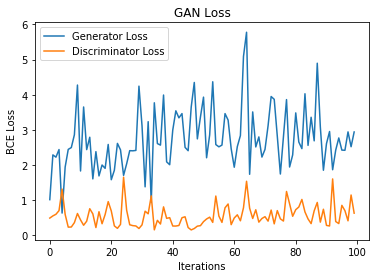

In [25]:
GAN.plot_gan_loss(G_loss_overtime, D_loss_overtime)

## Training our model on the small dataset with our GAN class

In [28]:
hp1 = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, 
                     output_dir="../generated_imgs",
                     lr=0.0002, beta1=0.5, epochs=100, batch_sz=64)
small_dataset = get_data_loader("../mini_data/")
g1 = GAN(hp1)
g1.fit(small_dataset)

Loading weight ../discriminator_trained_weights/gnet_90.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_90.pt for Generator



  0%|          | 0/100 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 0.2714161276817322
Generator Loss at epoch: 0, iter 0 = 3.154052734375



  1%|          | 1/100 [00:03<06:14,  3.78s/it]

Discriminator Loss at epoch: 1, iter 0 = 0.015406203456223011
Generator Loss at epoch: 1, iter 0 = 5.4661688804626465



  2%|▏         | 2/100 [00:08<06:23,  3.91s/it]

Discriminator Loss at epoch: 2, iter 0 = 1.5463693141937256
Generator Loss at epoch: 2, iter 0 = 2.5806195735931396



  3%|▎         | 3/100 [00:12<06:39,  4.12s/it]

Discriminator Loss at epoch: 3, iter 0 = 0.635512113571167
Generator Loss at epoch: 3, iter 0 = 5.190150260925293



  4%|▍         | 4/100 [00:16<06:34,  4.11s/it]

Discriminator Loss at epoch: 4, iter 0 = 0.23574446141719818
Generator Loss at epoch: 4, iter 0 = 4.377322196960449



  5%|▌         | 5/100 [00:20<06:29,  4.10s/it]

Discriminator Loss at epoch: 5, iter 0 = 0.33431634306907654
Generator Loss at epoch: 5, iter 0 = 4.95803165435791



  6%|▌         | 6/100 [00:24<06:23,  4.08s/it]

Discriminator Loss at epoch: 6, iter 0 = 0.48373985290527344
Generator Loss at epoch: 6, iter 0 = 4.7859086990356445



  7%|▋         | 7/100 [00:28<06:22,  4.11s/it]

Discriminator Loss at epoch: 7, iter 0 = 0.1716458946466446
Generator Loss at epoch: 7, iter 0 = 5.606947898864746



  8%|▊         | 8/100 [00:32<06:09,  4.01s/it]

Discriminator Loss at epoch: 8, iter 0 = 1.2877533435821533
Generator Loss at epoch: 8, iter 0 = 5.887701511383057



  9%|▉         | 9/100 [00:36<06:07,  4.04s/it]

Discriminator Loss at epoch: 9, iter 0 = 0.12768962979316711
Generator Loss at epoch: 9, iter 0 = 5.68284797668457



 10%|█         | 10/100 [00:41<06:16,  4.19s/it]

Discriminator Loss at epoch: 10, iter 0 = 0.33509188890457153
Generator Loss at epoch: 10, iter 0 = 4.637724876403809



 11%|█         | 11/100 [00:45<06:11,  4.18s/it]

Discriminator Loss at epoch: 11, iter 0 = 0.12786251306533813
Generator Loss at epoch: 11, iter 0 = 4.199770927429199



 12%|█▏        | 12/100 [00:49<06:04,  4.14s/it]

Discriminator Loss at epoch: 12, iter 0 = 0.35080885887145996
Generator Loss at epoch: 12, iter 0 = 5.911106586456299



 13%|█▎        | 13/100 [00:53<05:56,  4.10s/it]

Discriminator Loss at epoch: 13, iter 0 = 1.0398783683776855
Generator Loss at epoch: 13, iter 0 = 4.442173957824707



 14%|█▍        | 14/100 [00:57<05:51,  4.08s/it]

Discriminator Loss at epoch: 14, iter 0 = 0.10141082108020782
Generator Loss at epoch: 14, iter 0 = 4.708858966827393



 15%|█▌        | 15/100 [01:01<05:43,  4.04s/it]

Discriminator Loss at epoch: 15, iter 0 = 0.8163585662841797
Generator Loss at epoch: 15, iter 0 = 4.141700744628906



 16%|█▌        | 16/100 [01:05<05:39,  4.04s/it]

Discriminator Loss at epoch: 16, iter 0 = 0.7840877771377563
Generator Loss at epoch: 16, iter 0 = 2.2453036308288574



 17%|█▋        | 17/100 [01:09<05:35,  4.04s/it]

Discriminator Loss at epoch: 17, iter 0 = 1.2453644275665283
Generator Loss at epoch: 17, iter 0 = 6.763755798339844



 18%|█▊        | 18/100 [01:13<05:30,  4.03s/it]

Discriminator Loss at epoch: 18, iter 0 = 0.23123270273208618
Generator Loss at epoch: 18, iter 0 = 4.716520309448242



 19%|█▉        | 19/100 [01:18<05:43,  4.24s/it]

Discriminator Loss at epoch: 19, iter 0 = 0.8381882905960083
Generator Loss at epoch: 19, iter 0 = 6.20436954498291



 20%|██        | 20/100 [01:22<05:32,  4.15s/it]

Discriminator Loss at epoch: 20, iter 0 = 0.279288113117218
Generator Loss at epoch: 20, iter 0 = 4.572755813598633



 21%|██        | 21/100 [01:26<05:25,  4.12s/it]

Discriminator Loss at epoch: 21, iter 0 = 0.43881821632385254
Generator Loss at epoch: 21, iter 0 = 3.845395803451538



 22%|██▏       | 22/100 [01:30<05:19,  4.10s/it]

Discriminator Loss at epoch: 22, iter 0 = 0.9653716087341309
Generator Loss at epoch: 22, iter 0 = 3.6064019203186035



 23%|██▎       | 23/100 [01:34<05:12,  4.06s/it]

Discriminator Loss at epoch: 23, iter 0 = 0.3766833543777466
Generator Loss at epoch: 23, iter 0 = 3.923429489135742



 24%|██▍       | 24/100 [01:38<05:08,  4.06s/it]

Discriminator Loss at epoch: 24, iter 0 = 0.7685054540634155
Generator Loss at epoch: 24, iter 0 = 4.206501483917236



 25%|██▌       | 25/100 [01:42<05:12,  4.16s/it]

Discriminator Loss at epoch: 25, iter 0 = 1.8823782205581665
Generator Loss at epoch: 25, iter 0 = 2.129472017288208



 26%|██▌       | 26/100 [01:46<05:02,  4.09s/it]

Discriminator Loss at epoch: 26, iter 0 = 0.5655657052993774
Generator Loss at epoch: 26, iter 0 = 5.486574172973633



 27%|██▋       | 27/100 [01:50<04:53,  4.02s/it]

Discriminator Loss at epoch: 27, iter 0 = 0.5504202842712402
Generator Loss at epoch: 27, iter 0 = 2.9782865047454834



 28%|██▊       | 28/100 [01:54<04:47,  4.00s/it]

Discriminator Loss at epoch: 28, iter 0 = 0.6909208297729492
Generator Loss at epoch: 28, iter 0 = 4.285668849945068



 29%|██▉       | 29/100 [01:58<04:43,  3.99s/it]

Discriminator Loss at epoch: 29, iter 0 = 1.6356558799743652
Generator Loss at epoch: 29, iter 0 = 5.386567115783691



 30%|███       | 30/100 [02:02<04:40,  4.01s/it]

Discriminator Loss at epoch: 30, iter 0 = 0.3878919780254364
Generator Loss at epoch: 30, iter 0 = 2.798490524291992



 31%|███       | 31/100 [02:06<04:38,  4.03s/it]

Discriminator Loss at epoch: 31, iter 0 = 0.7988347411155701
Generator Loss at epoch: 31, iter 0 = 6.050369739532471



 32%|███▏      | 32/100 [02:11<04:39,  4.11s/it]

Discriminator Loss at epoch: 32, iter 0 = 1.2193677425384521
Generator Loss at epoch: 32, iter 0 = 4.013647079467773



 33%|███▎      | 33/100 [02:15<04:33,  4.08s/it]

Discriminator Loss at epoch: 33, iter 0 = 1.5567262172698975
Generator Loss at epoch: 33, iter 0 = 8.268945693969727



 34%|███▍      | 34/100 [02:19<04:36,  4.19s/it]

Discriminator Loss at epoch: 34, iter 0 = 0.7193228006362915
Generator Loss at epoch: 34, iter 0 = 4.033636569976807



 35%|███▌      | 35/100 [02:23<04:32,  4.19s/it]

Discriminator Loss at epoch: 35, iter 0 = 0.9660996198654175
Generator Loss at epoch: 35, iter 0 = 4.159087657928467



 36%|███▌      | 36/100 [02:27<04:26,  4.16s/it]

Discriminator Loss at epoch: 36, iter 0 = 0.15521903336048126
Generator Loss at epoch: 36, iter 0 = 5.116477966308594



 37%|███▋      | 37/100 [02:31<04:21,  4.16s/it]

Discriminator Loss at epoch: 37, iter 0 = 1.6679365634918213
Generator Loss at epoch: 37, iter 0 = 3.4641757011413574



 38%|███▊      | 38/100 [02:36<04:16,  4.14s/it]

Discriminator Loss at epoch: 38, iter 0 = 0.5359369516372681
Generator Loss at epoch: 38, iter 0 = 2.378218650817871



 39%|███▉      | 39/100 [02:40<04:20,  4.27s/it]

Discriminator Loss at epoch: 39, iter 0 = 0.8137494921684265
Generator Loss at epoch: 39, iter 0 = 0.8343470096588135



 40%|████      | 40/100 [02:44<04:09,  4.15s/it]

Discriminator Loss at epoch: 40, iter 0 = 0.7417871356010437
Generator Loss at epoch: 40, iter 0 = 2.6095242500305176



 41%|████      | 41/100 [02:48<04:01,  4.09s/it]

Discriminator Loss at epoch: 41, iter 0 = 0.8104246854782104
Generator Loss at epoch: 41, iter 0 = 3.7072958946228027



 42%|████▏     | 42/100 [02:52<03:56,  4.07s/it]

Discriminator Loss at epoch: 42, iter 0 = 1.0738104581832886
Generator Loss at epoch: 42, iter 0 = 2.731499671936035



 43%|████▎     | 43/100 [02:56<03:50,  4.04s/it]

Discriminator Loss at epoch: 43, iter 0 = 0.7049455642700195
Generator Loss at epoch: 43, iter 0 = 1.9696624279022217



 44%|████▍     | 44/100 [03:00<03:47,  4.07s/it]

Discriminator Loss at epoch: 44, iter 0 = 0.502007246017456
Generator Loss at epoch: 44, iter 0 = 3.1097941398620605



 45%|████▌     | 45/100 [03:04<03:43,  4.06s/it]

Discriminator Loss at epoch: 45, iter 0 = 0.5661680102348328
Generator Loss at epoch: 45, iter 0 = 5.331399440765381



 46%|████▌     | 46/100 [03:08<03:36,  4.01s/it]

Discriminator Loss at epoch: 46, iter 0 = 1.2750662565231323
Generator Loss at epoch: 46, iter 0 = 5.387781143188477



 47%|████▋     | 47/100 [03:12<03:31,  3.99s/it]

Discriminator Loss at epoch: 47, iter 0 = 0.3253340423107147
Generator Loss at epoch: 47, iter 0 = 3.463900566101074



 48%|████▊     | 48/100 [03:16<03:26,  3.98s/it]

Discriminator Loss at epoch: 48, iter 0 = 0.19513103365898132
Generator Loss at epoch: 48, iter 0 = 4.87217903137207



 49%|████▉     | 49/100 [03:20<03:24,  4.01s/it]

Discriminator Loss at epoch: 49, iter 0 = 1.3437635898590088
Generator Loss at epoch: 49, iter 0 = 5.052617073059082



 50%|█████     | 50/100 [03:25<03:33,  4.27s/it]

Discriminator Loss at epoch: 50, iter 0 = 0.6301249265670776
Generator Loss at epoch: 50, iter 0 = 2.4525208473205566



 51%|█████     | 51/100 [03:29<03:23,  4.16s/it]

Discriminator Loss at epoch: 51, iter 0 = 0.8892245292663574
Generator Loss at epoch: 51, iter 0 = 6.157757759094238



 52%|█████▏    | 52/100 [03:33<03:15,  4.08s/it]

Discriminator Loss at epoch: 52, iter 0 = 1.491617202758789
Generator Loss at epoch: 52, iter 0 = 4.95188045501709



 53%|█████▎    | 53/100 [03:37<03:10,  4.06s/it]

Discriminator Loss at epoch: 53, iter 0 = 0.37582558393478394
Generator Loss at epoch: 53, iter 0 = 4.697523593902588



 54%|█████▍    | 54/100 [03:41<03:16,  4.28s/it]

Discriminator Loss at epoch: 54, iter 0 = 0.7676321268081665
Generator Loss at epoch: 54, iter 0 = 3.8884549140930176



 55%|█████▌    | 55/100 [03:45<03:08,  4.18s/it]

Discriminator Loss at epoch: 55, iter 0 = 1.2405548095703125
Generator Loss at epoch: 55, iter 0 = 3.278095006942749



 56%|█████▌    | 56/100 [03:50<03:03,  4.17s/it]

Discriminator Loss at epoch: 56, iter 0 = 0.9014707803726196
Generator Loss at epoch: 56, iter 0 = 1.0522280931472778



 57%|█████▋    | 57/100 [03:54<02:59,  4.18s/it]

Discriminator Loss at epoch: 57, iter 0 = 1.3510956764221191
Generator Loss at epoch: 57, iter 0 = 5.0505523681640625



 58%|█████▊    | 58/100 [03:58<02:52,  4.12s/it]

Discriminator Loss at epoch: 58, iter 0 = 0.9851689338684082
Generator Loss at epoch: 58, iter 0 = 4.486946105957031



 59%|█████▉    | 59/100 [04:02<02:45,  4.03s/it]

Discriminator Loss at epoch: 59, iter 0 = 1.0309202671051025
Generator Loss at epoch: 59, iter 0 = 3.7123680114746094



 60%|██████    | 60/100 [04:06<02:41,  4.03s/it]

Discriminator Loss at epoch: 60, iter 0 = 0.48590540885925293
Generator Loss at epoch: 60, iter 0 = 3.8393402099609375



 61%|██████    | 61/100 [04:09<02:35,  3.98s/it]

Discriminator Loss at epoch: 61, iter 0 = 0.5274093747138977
Generator Loss at epoch: 61, iter 0 = 5.24628210067749



 62%|██████▏   | 62/100 [04:14<02:33,  4.03s/it]

Discriminator Loss at epoch: 62, iter 0 = 0.4979315996170044
Generator Loss at epoch: 62, iter 0 = 4.24357271194458



 63%|██████▎   | 63/100 [04:18<02:29,  4.05s/it]

Discriminator Loss at epoch: 63, iter 0 = 1.8246612548828125
Generator Loss at epoch: 63, iter 0 = 0.7841494083404541



 64%|██████▍   | 64/100 [04:22<02:24,  4.02s/it]

Discriminator Loss at epoch: 64, iter 0 = 1.1675673723220825
Generator Loss at epoch: 64, iter 0 = 6.195089340209961



 65%|██████▌   | 65/100 [04:26<02:22,  4.07s/it]

Discriminator Loss at epoch: 65, iter 0 = 0.5940215587615967
Generator Loss at epoch: 65, iter 0 = 2.1985726356506348



 66%|██████▌   | 66/100 [04:30<02:21,  4.15s/it]

Discriminator Loss at epoch: 66, iter 0 = 0.3588326573371887
Generator Loss at epoch: 66, iter 0 = 4.572836875915527



 67%|██████▋   | 67/100 [04:34<02:15,  4.09s/it]

Discriminator Loss at epoch: 67, iter 0 = 0.10403239727020264
Generator Loss at epoch: 67, iter 0 = 4.7737321853637695


KeyboardInterrupt: 

### Plotting its loss function

In [29]:
g1.plot_loss()

AttributeError: type object 'GAN' has no attribute 'plot_loss_curve'

## Training our model on the full dataset with our GAN class

In [ ]:
# WARNING: Big dataset is huge, so should use fewer epochs
hp2 = HyperParameter(latent_sz=100, in_img_size=64, in_img_channel=3, 
                     output_dir="../generated_imgs",
                     lr=0.0002, beta1=0.5, epochs=10, batch_sz=64)
big_dataset = get_data_loader("../data/img_align_celeba/")
g2 = GAN(hp2)
g2.fit(big_dataset)

Loading weight ../discriminator_trained_weights/gnet_epoch_67_iter_0.pt for Discriminator
Loading weight ../generator_trained_weights/gnet_epoch_67_iter_0.pt for Generator




  0%|          | 0/10 [00:00<?, ?it/s]

Discriminator Loss at epoch: 0, iter 0 = 0.26854756474494934
Generator Loss at epoch: 0, iter 0 = 4.506418228149414
Discriminator Loss at epoch: 0, iter 10 = 0.08776470273733139
Generator Loss at epoch: 0, iter 10 = 4.87294864654541
Discriminator Loss at epoch: 0, iter 20 = 0.10007470846176147
Generator Loss at epoch: 0, iter 20 = 4.455535411834717
Discriminator Loss at epoch: 0, iter 30 = 0.14859245717525482
Generator Loss at epoch: 0, iter 30 = 4.926784515380859
Discriminator Loss at epoch: 0, iter 40 = 0.20604735612869263
Generator Loss at epoch: 0, iter 40 = 5.940629959106445
Discriminator Loss at epoch: 0, iter 50 = 0.22873365879058838
Generator Loss at epoch: 0, iter 50 = 3.4873294830322266
Discriminator Loss at epoch: 0, iter 60 = 0.24626193940639496
Generator Loss at epoch: 0, iter 60 = 4.887941360473633
Discriminator Loss at epoch: 0, iter 70 = 0.23680070042610168
Generator Loss at epoch: 0, iter 70 = 5.0799078941345215
Discriminator Loss at epoch: 0, iter 80 = 1.6336243152618

Discriminator Loss at epoch: 0, iter 690 = 1.2165673971176147
Generator Loss at epoch: 0, iter 690 = 5.984757423400879
Discriminator Loss at epoch: 0, iter 700 = 0.3477962017059326
Generator Loss at epoch: 0, iter 700 = 3.1772093772888184
Discriminator Loss at epoch: 0, iter 710 = 0.4129464626312256
Generator Loss at epoch: 0, iter 710 = 3.389273166656494
Discriminator Loss at epoch: 0, iter 720 = 0.7773125171661377
Generator Loss at epoch: 0, iter 720 = 6.879718780517578
Discriminator Loss at epoch: 0, iter 730 = 1.197854995727539
Generator Loss at epoch: 0, iter 730 = 4.16965389251709
Discriminator Loss at epoch: 0, iter 740 = 0.8086649179458618
Generator Loss at epoch: 0, iter 740 = 2.2169837951660156
Discriminator Loss at epoch: 0, iter 750 = 0.4730989336967468
Generator Loss at epoch: 0, iter 750 = 4.288393974304199
Discriminator Loss at epoch: 0, iter 760 = 0.6782304048538208
Generator Loss at epoch: 0, iter 760 = 4.435580253601074
Discriminator Loss at epoch: 0, iter 770 = 2.441

Discriminator Loss at epoch: 0, iter 1370 = 0.8715469837188721
Generator Loss at epoch: 0, iter 1370 = 3.0148367881774902
Discriminator Loss at epoch: 0, iter 1380 = 0.37047117948532104
Generator Loss at epoch: 0, iter 1380 = 3.3998124599456787
Discriminator Loss at epoch: 0, iter 1390 = 0.22455236315727234
Generator Loss at epoch: 0, iter 1390 = 3.5607099533081055
Discriminator Loss at epoch: 0, iter 1400 = 0.33175837993621826
Generator Loss at epoch: 0, iter 1400 = 3.509444236755371
Discriminator Loss at epoch: 0, iter 1410 = 1.0111119747161865
Generator Loss at epoch: 0, iter 1410 = 3.230851173400879
Discriminator Loss at epoch: 0, iter 1420 = 0.5449591279029846
Generator Loss at epoch: 0, iter 1420 = 1.1354732513427734
Discriminator Loss at epoch: 0, iter 1430 = 0.3527810871601105
Generator Loss at epoch: 0, iter 1430 = 2.692857027053833
Discriminator Loss at epoch: 0, iter 1440 = 0.2822660803794861
Generator Loss at epoch: 0, iter 1440 = 3.5072648525238037
Discriminator Loss at ep



 10%|█         | 1/10 [22:53<3:26:04, 1373.80s/it]

Discriminator Loss at epoch: 1, iter 0 = 0.8965212106704712
Generator Loss at epoch: 1, iter 0 = 5.349118232727051
Discriminator Loss at epoch: 1, iter 10 = 1.199429988861084
Generator Loss at epoch: 1, iter 10 = 2.279597282409668
Discriminator Loss at epoch: 1, iter 20 = 0.3082229495048523
Generator Loss at epoch: 1, iter 20 = 3.275275707244873
Discriminator Loss at epoch: 1, iter 30 = 0.7186363339424133
Generator Loss at epoch: 1, iter 30 = 2.173389434814453
Discriminator Loss at epoch: 1, iter 40 = 0.20340560376644135
Generator Loss at epoch: 1, iter 40 = 3.935690402984619
Discriminator Loss at epoch: 1, iter 50 = 0.32161617279052734
Generator Loss at epoch: 1, iter 50 = 3.8648715019226074
Discriminator Loss at epoch: 1, iter 60 = 0.917025625705719
Generator Loss at epoch: 1, iter 60 = 4.805911064147949
Discriminator Loss at epoch: 1, iter 70 = 0.4586246609687805
Generator Loss at epoch: 1, iter 70 = 2.474548578262329
Discriminator Loss at epoch: 1, iter 80 = 0.4454667866230011
Gene

Discriminator Loss at epoch: 1, iter 690 = 1.4059122800827026
Generator Loss at epoch: 1, iter 690 = 4.286336898803711
Discriminator Loss at epoch: 1, iter 700 = 0.5482801198959351
Generator Loss at epoch: 1, iter 700 = 2.6676478385925293
Discriminator Loss at epoch: 1, iter 710 = 0.2974207103252411
Generator Loss at epoch: 1, iter 710 = 3.593747615814209
Discriminator Loss at epoch: 1, iter 720 = 0.1745116114616394
Generator Loss at epoch: 1, iter 720 = 6.052447319030762
Discriminator Loss at epoch: 1, iter 730 = 0.8145339488983154
Generator Loss at epoch: 1, iter 730 = 4.8017401695251465
Discriminator Loss at epoch: 1, iter 740 = 0.5068588852882385
Generator Loss at epoch: 1, iter 740 = 2.858524799346924
Discriminator Loss at epoch: 1, iter 750 = 0.459367573261261
Generator Loss at epoch: 1, iter 750 = 2.2354934215545654
Discriminator Loss at epoch: 1, iter 760 = 0.9212467670440674
Generator Loss at epoch: 1, iter 760 = 5.3700480461120605
Discriminator Loss at epoch: 1, iter 770 = 1.

Discriminator Loss at epoch: 1, iter 1370 = 0.7140134572982788
Generator Loss at epoch: 1, iter 1370 = 4.425264358520508
Discriminator Loss at epoch: 1, iter 1380 = 0.5594560503959656
Generator Loss at epoch: 1, iter 1380 = 3.855586528778076
Discriminator Loss at epoch: 1, iter 1390 = 0.4998571574687958
Generator Loss at epoch: 1, iter 1390 = 4.996293067932129
Discriminator Loss at epoch: 1, iter 1400 = 0.20221570134162903
Generator Loss at epoch: 1, iter 1400 = 4.505044460296631
Discriminator Loss at epoch: 1, iter 1410 = 0.5137996673583984
Generator Loss at epoch: 1, iter 1410 = 5.125196933746338
Discriminator Loss at epoch: 1, iter 1420 = 0.9355617761611938
Generator Loss at epoch: 1, iter 1420 = 2.669576406478882
Discriminator Loss at epoch: 1, iter 1430 = 0.36271870136260986
Generator Loss at epoch: 1, iter 1430 = 3.775750160217285
Discriminator Loss at epoch: 1, iter 1440 = 0.17896848917007446
Generator Loss at epoch: 1, iter 1440 = 4.46954870223999
Discriminator Loss at epoch: 1



 20%|██        | 2/10 [45:40<3:02:52, 1371.59s/it]

Discriminator Loss at epoch: 2, iter 0 = 0.3700067102909088
Generator Loss at epoch: 2, iter 0 = 2.703176498413086
Discriminator Loss at epoch: 2, iter 10 = 0.540235161781311
Generator Loss at epoch: 2, iter 10 = 6.951602458953857
Discriminator Loss at epoch: 2, iter 20 = 0.16911283135414124
Generator Loss at epoch: 2, iter 20 = 3.6385302543640137
Discriminator Loss at epoch: 2, iter 30 = 0.2845982611179352
Generator Loss at epoch: 2, iter 30 = 2.8155674934387207
Discriminator Loss at epoch: 2, iter 40 = 0.5450528264045715
Generator Loss at epoch: 2, iter 40 = 4.035794258117676
Discriminator Loss at epoch: 2, iter 50 = 0.6965581774711609
Generator Loss at epoch: 2, iter 50 = 5.365011215209961
Discriminator Loss at epoch: 2, iter 60 = 0.8429873585700989
Generator Loss at epoch: 2, iter 60 = 3.5985727310180664
Discriminator Loss at epoch: 2, iter 70 = 0.2674090266227722
Generator Loss at epoch: 2, iter 70 = 2.838999032974243
Discriminator Loss at epoch: 2, iter 80 = 1.216196894645691
Gen

Discriminator Loss at epoch: 2, iter 690 = 0.47911548614501953
Generator Loss at epoch: 2, iter 690 = 3.800398111343384
Discriminator Loss at epoch: 2, iter 700 = 0.22018323838710785
Generator Loss at epoch: 2, iter 700 = 3.4985339641571045
Discriminator Loss at epoch: 2, iter 710 = 0.4556635320186615
Generator Loss at epoch: 2, iter 710 = 3.3327388763427734
Discriminator Loss at epoch: 2, iter 720 = 0.4420013427734375
Generator Loss at epoch: 2, iter 720 = 2.956904411315918
Discriminator Loss at epoch: 2, iter 730 = 0.7037281394004822
Generator Loss at epoch: 2, iter 730 = 1.9089399576187134
Discriminator Loss at epoch: 2, iter 740 = 0.5158288478851318
Generator Loss at epoch: 2, iter 740 = 1.8643758296966553
Discriminator Loss at epoch: 2, iter 750 = 0.309274286031723
Generator Loss at epoch: 2, iter 750 = 3.9008936882019043
Discriminator Loss at epoch: 2, iter 760 = 0.5567043423652649
Generator Loss at epoch: 2, iter 760 = 3.979093313217163
Discriminator Loss at epoch: 2, iter 770 =

Discriminator Loss at epoch: 2, iter 1370 = 0.5436238646507263
Generator Loss at epoch: 2, iter 1370 = 3.8731579780578613
Discriminator Loss at epoch: 2, iter 1380 = 1.0764836072921753
Generator Loss at epoch: 2, iter 1380 = 2.589395523071289
Discriminator Loss at epoch: 2, iter 1390 = 0.882404625415802
Generator Loss at epoch: 2, iter 1390 = 2.447031259536743


### Plotting its loss function

In [ ]:
g2.plot_loss()